In [ ]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
def get_clouds():
    Nclass = 3000
    D = 2

    X1 = np.random.randn(Nclass, D) + np.array([0, -2])
    X2 = np.random.randn(Nclass, D) + np.array([2, 2])
    X3 = np.random.randn(Nclass, D) + np.array([-2, 2])
    X = np.vstack([X1, X2, X3])

    Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)
    return X, Y

In [ ]:
def predict(p_y):
    return np.argmax(p_y, axis=1)

In [ ]:
def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(prediction != t)

In [ ]:
def cost(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()

In [ ]:
def y2indicator(y): # For one row [1, 0, 0] or [0, 1, 0] , [0, 0, 1] it can be [0, 1, 1] if you task multilabel
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 3))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind


In [ ]:
def forward(X, W1, b1, W2, b2):
    # sigmoid
    # Z = 1 / (1 + np.exp(-( X.dot(W1) + b1 )))

    # relu
    Z = X.dot(W1) + b1
    Z[Z < 0] = 0

    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

def derivative_w2(Z, T, Y):
    return Z.T.dot(Y - T)

def derivative_b2(T, Y):
    return (Y - T).sum(axis=0)

def derivative_w1(X, Z, T, Y, W2):
    # return X.T.dot( ( ( Y-T ).dot(W2.T) * ( Z*(1 - Z) ) ) ) # for sigmoid
    return X.T.dot( ( ( Y-T ).dot(W2.T) * (Z > 0) ) ) # for relu

def derivative_b1(Z, T, Y, W2):
    # return (( Y-T ).dot(W2.T) * ( Z*(1 - Z) )).sum(axis=0) # for sigmoid
    return (( Y-T ).dot(W2.T) * (Z > 0)).sum(axis=0) # for relu

In [ ]:
max_iter = 10
print_period = 10

X, Y = get_clouds()
reg = 0.01

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 3
W1_0 = np.random.randn(D, M) / np.sqrt(D)
b1_0 = np.zeros(M)
W2_0 = np.random.randn(M, K) / np.sqrt(M)
b2_0 = np.zeros(K)

W1 = W1_0.copy()
b1 = b1_0.copy()
W2 = W2_0.copy()
b2 = b2_0.copy()

# 1st moment
mW1 = 0
mb1 = 0
mW2 = 0
mb2 = 0

# 2nd moment
vW1 = 0
vb1 = 0
vW2 = 0
vb2 = 0

# hyperparams
lr0 = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 1e-8

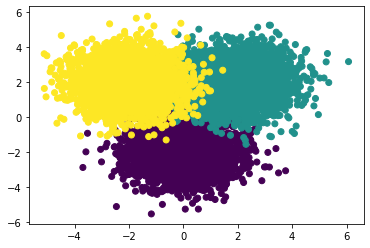

In [ ]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y)
plt.show()

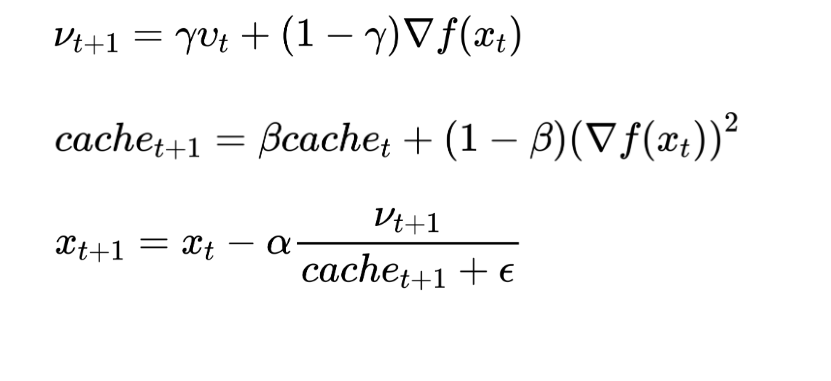

In [ ]:
# 1. Adam
loss_adam = []
err_adam = []
t = 1
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

        # updates
        # gradients
        gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
        gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
        gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1

        # new m
        mW1 = beta1 * mW1 + (1 - beta1) * gW1
        mb1 = beta1 * mb1 + (1 - beta1) * gb1
        mW2 = beta1 * mW2 + (1 - beta1) * gW2
        mb2 = beta1 * mb2 + (1 - beta1) * gb2

        # new v
        vW1 = beta2 * vW1 + (1 - beta2) * gW1 * gW1
        vb1 = beta2 * vb1 + (1 - beta2) * gb1 * gb1
        vW2 = beta2 * vW2 + (1 - beta2) * gW2 * gW2
        vb2 = beta2 * vb2 + (1 - beta2) * gb2 * gb2

        # bias correction
        correction1 = 1 - beta1 ** t
        hat_mW1 = mW1 / correction1
        hat_mb1 = mb1 / correction1
        hat_mW2 = mW2 / correction1
        hat_mb2 = mb2 / correction1

        correction2 = 1 - beta2 ** t
        hat_vW1 = vW1 / correction2
        hat_vb1 = vb1 / correction2
        hat_vW2 = vW2 / correction2
        hat_vb2 = vb2 / correction2

        # update t
        t += 1

        # apply updates to the params
        W1 = W1 - lr0 * hat_mW1 / np.sqrt(hat_vW1 + eps)
        b1 = b1 - lr0 * hat_mb1 / np.sqrt(hat_vb1 + eps)
        W2 = W2 - lr0 * hat_mW2 / np.sqrt(hat_vW2 + eps)
        b2 = b2 - lr0 * hat_mb2 / np.sqrt(hat_vb2 + eps)


        if j % print_period == 0:
            pY, _ = forward(Xtest, W1, b1, W2, b2)
            l = cost(pY, Ytest_ind)
            loss_adam.append(l)
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

            err = error_rate(pY, Ytest)
            err_adam.append(err)
            print("Error rate:", err)

pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))






Cost at iteration i=0, j=0: 2404.118081
Error rate: 1.0
Cost at iteration i=0, j=10: 4448.573947
Error rate: 1.0
Cost at iteration i=1, j=0: 3166.941125
Error rate: 1.0
Cost at iteration i=1, j=10: 1557.978207
Error rate: 0.999
Cost at iteration i=2, j=0: 729.956718
Error rate: 0.293
Cost at iteration i=2, j=10: 264.904337
Error rate: 0.062
Cost at iteration i=3, j=0: 188.228523
Error rate: 0.041
Cost at iteration i=3, j=10: 144.736110
Error rate: 0.03
Cost at iteration i=4, j=0: 134.893262
Error rate: 0.031
Cost at iteration i=4, j=10: 131.207944
Error rate: 0.032
Cost at iteration i=5, j=0: 129.135692
Error rate: 0.034
Cost at iteration i=5, j=10: 130.004996
Error rate: 0.036
Cost at iteration i=6, j=0: 127.754420
Error rate: 0.037
Cost at iteration i=6, j=10: 127.698633
Error rate: 0.038
Cost at iteration i=7, j=0: 124.745239
Error rate: 0.038
Cost at iteration i=7, j=10: 123.933673
Error rate: 0.037
Cost at iteration i=8, j=0: 120.873815
Error rate: 0.036
Cost at iteration i=8, j=1

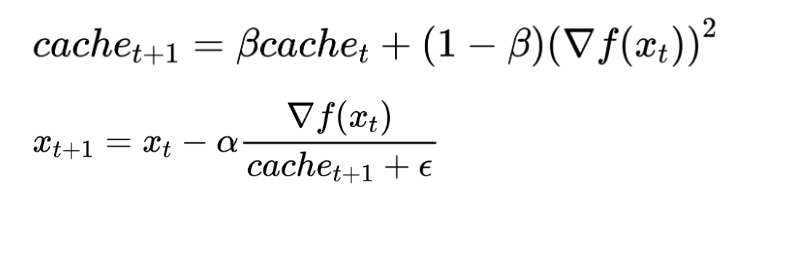

In [ ]:
# 2. RMSprop with momentum
W1 = W1_0.copy()
b1 = b1_0.copy()
W2 = W2_0.copy()
b2 = b2_0.copy()
loss_rms = []
err_rms = []

# comparable hyperparameters for fair comparison
lr0 = 0.001
mu = 0.9
decay_rate = 0.999
eps = 1e-8

# rmsprop cache
cache_W2 = 1
cache_b2 = 1
cache_W1 = 1
cache_b1 = 1

# momentum
dW1 = 0
db1 = 0
dW2 = 0
db2 = 0

for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

        # updates
        gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
        cache_W2 = decay_rate*cache_W2 + (1 - decay_rate)*gW2*gW2
        dW2 = mu * dW2 + (1 - mu) * lr0 * gW2 / (np.sqrt(cache_W2) + eps)
        W2 -= dW2

        gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
        cache_b2 = decay_rate*cache_b2 + (1 - decay_rate)*gb2*gb2
        db2 = mu * db2 + (1 - mu) * lr0 * gb2 / (np.sqrt(cache_b2) + eps)
        b2 -= db2

        gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
        cache_W1 = decay_rate*cache_W1 + (1 - decay_rate)*gW1*gW1
        dW1 = mu * dW1 + (1 - mu) * lr0 * gW1 / (np.sqrt(cache_W1) + eps)
        W1 -= dW1

        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1
        cache_b1 = decay_rate*cache_b1 + (1 - decay_rate)*gb1*gb1
        db1 = mu * db1 + (1 - mu) * lr0 * gb1 / (np.sqrt(cache_b1) + eps)
        b1 -= db1

        if j % print_period == 0:
            pY, _ = forward(Xtest, W1, b1, W2, b2)
            l = cost(pY, Ytest_ind)
            loss_rms.append(l)
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))

            err = error_rate(pY, Ytest)
            err_rms.append(err)
            print("Error rate:", err)

pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))

Cost at iteration i=0, j=0: 2466.811230
Error rate: 1.0
Cost at iteration i=0, j=10: 7361.633272
Error rate: 1.0
Cost at iteration i=1, j=0: 918.375359
Error rate: 0.327
Cost at iteration i=1, j=10: 36.350377
Error rate: 0.01
Cost at iteration i=2, j=0: 29.448207
Error rate: 0.008
Cost at iteration i=2, j=10: 34.260460
Error rate: 0.009
Cost at iteration i=3, j=0: 45.051723
Error rate: 0.01
Cost at iteration i=3, j=10: 61.212388
Error rate: 0.016
Cost at iteration i=4, j=0: 70.201476
Error rate: 0.02
Cost at iteration i=4, j=10: 81.534656
Error rate: 0.025
Cost at iteration i=5, j=0: 84.926223
Error rate: 0.027
Cost at iteration i=5, j=10: 89.885565
Error rate: 0.029
Cost at iteration i=6, j=0: 90.182716
Error rate: 0.029
Cost at iteration i=6, j=10: 92.579228
Error rate: 0.031
Cost at iteration i=7, j=0: 92.021069
Error rate: 0.031
Cost at iteration i=7, j=10: 93.904098
Error rate: 0.031
Cost at iteration i=8, j=0: 93.243413
Error rate: 0.031
Cost at iteration i=8, j=10: 95.123701
Err

In [ ]:
pY

array([[1.01194939e-09, 1.60875615e-06, 9.99998390e-01],
       [6.11761526e-11, 2.88485121e-08, 9.99999971e-01],
       [6.34234050e-12, 1.37524595e-03, 9.98624754e-01],
       ...,
       [9.85954151e-08, 1.53955865e-02, 9.84604315e-01],
       [1.79114991e-12, 4.49725220e-06, 9.99995503e-01],
       [6.99236058e-06, 1.63913441e-03, 9.98353873e-01]])

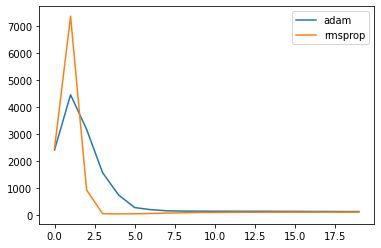

In [ ]:
plt.plot(loss_adam, label='adam')
plt.plot(loss_rms, label='rmsprop')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# for binary classification! no softmax here

def forward(X, W1, b1, W2, b2):
    # sigmoid
    # Z = 1 / (1 + np.exp( -(X.dot(W1) + b1) ))

    # tanh
    # Z = np.tanh(X.dot(W1) + b1)

    # relu
    Z = X.dot(W1) + b1
    Z = Z * (Z > 0)

    activation = Z.dot(W2) + b2
    Y = 1 / (1 + np.exp(-activation))
    return Y, Z


def predict(X, W1, b1, W2, b2):
    Y, _ = forward(X, W1, b1, W2, b2)
    return np.round(Y)


def derivative_w2(Z, T, Y):
    # Z is (N, M)
    return (T - Y).dot(Z)

def derivative_b2(T, Y):
    return (T - Y).sum()


def derivative_w1(X, Z, T, Y, W2):
    # dZ = np.outer(T-Y, W2) * Z * (1 - Z) # this is for sigmoid activation
    # dZ = np.outer(T-Y, W2) * (1 - Z * Z) # this is for tanh activation
    dZ = np.outer(T-Y, W2) * (Z > 0) # this is for relu activation
    return X.T.dot(dZ)


def derivative_b1(Z, T, Y, W2):
    # dZ = np.outer(T-Y, W2) * Z * (1 - Z) # this is for sigmoid activation
    # dZ = np.outer(T-Y, W2) * (1 - Z * Z) # this is for tanh activation
    dZ = np.outer(T-Y, W2) * (Z > 0) # this is for relu activation
    return dZ.sum(axis=0)


def get_log_likelihood(T, Y):
    return np.sum(T*np.log(Y) + (1-T)*np.log(1-Y))



def test_xor():
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    Y = np.array([0, 1, 1, 0])
    W1 = np.random.randn(2, 5)
    b1 = np.zeros(5)
    W2 = np.random.randn(5)
    b2 = 0
    LL = [] # keep track of log-likelihoods
    learning_rate = 1e-2
    regularization = 0.
    last_error_rate = None
    for i in range(30000):
        pY, Z = forward(X, W1, b1, W2, b2)
        ll = get_log_likelihood(Y, pY)
        prediction = predict(X, W1, b1, W2, b2)
        er = np.mean(prediction != Y)

        LL.append(ll)
        W2 += learning_rate * (derivative_w2(Z, Y, pY) - regularization * W2)
        b2 += learning_rate * (derivative_b2(Y, pY) - regularization * b2)
        W1 += learning_rate * (derivative_w1(X, Z, Y, pY, W2) - regularization * W1)
        b1 += learning_rate * (derivative_b1(Z, Y, pY, W2) - regularization * b1)
        if i % 1000 == 0:
            print(ll)

    print("final classification rate:", np.mean(prediction == Y))
    plt.plot(LL)
    plt.show()


def test_donut():
    # donut example
    N = 1000
    R_inner = 5
    R_outer = 10

    # distance from origin is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

    X = np.concatenate([ X_inner, X_outer ])
    Y = np.array([0]*(N//2) + [1]*(N//2))

    n_hidden = 8
    W1 = np.random.randn(2, n_hidden)
    b1 = np.random.randn(n_hidden)
    W2 = np.random.randn(n_hidden)
    b2 = np.random.randn(1)
    LL = [] # keep track of log-likelihoods
    learning_rate = 0.00005
    regularization = 0.2
    last_error_rate = None
    for i in range(3000):
        pY, Z = forward(X, W1, b1, W2, b2)
        ll = get_log_likelihood(Y, pY)
        prediction = predict(X, W1, b1, W2, b2)
        er = np.abs(prediction - Y).mean()
        LL.append(ll)
        W2 += learning_rate * (derivative_w2(Z, Y, pY) - regularization * W2)
        b2 += learning_rate * (derivative_b2(Y, pY) - regularization * b2)
        W1 += learning_rate * (derivative_w1(X, Z, Y, pY, W2) - regularization * W1)
        b1 += learning_rate * (derivative_b1(Z, Y, pY, W2) - regularization * b1)
        if i % 300 == 0:
            print("i:", i, "ll:", ll, "classification rate:", 1 - er)
    plt.plot(LL)
    plt.show()

i: 0 ll: -11954.36399481633 classification rate: 0.513
i: 300 ll: -109.57060815582422 classification rate: 0.989
i: 600 ll: -64.7009967638869 classification rate: 0.99
i: 900 ll: -49.503519142592545 classification rate: 0.991
i: 1200 ll: -41.91831398634354 classification rate: 0.991
i: 1500 ll: -37.38106931814161 classification rate: 0.991
i: 1800 ll: -34.302994736795924 classification rate: 0.991
i: 2100 ll: -32.136834131541704 classification rate: 0.991
i: 2400 ll: -30.51298872093251 classification rate: 0.991
i: 2700 ll: -29.24419177666053 classification rate: 0.991


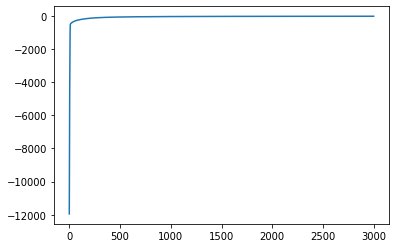

In [ ]:
test_donut()

-3.6422238085293643
-0.5694958583627636
-0.15421279090707554
-0.08294839594141838
-0.05552882426903885
-0.04137820212502322
-0.03280575000571066
-0.02708990343047048
-0.02302572967531931
-0.019992320235974192
-0.017649038848463493
-0.015784777149726453
-0.014265567912947998
-0.01300671372106171
-0.011946995119164229
-0.01104361078940889
-0.0102643225746455
-0.00958518518244395
-0.008988070000997883
-0.008460425705987205
-0.007989045456488196
-0.007566746011008641
-0.007185314285790682
-0.0068400773793376515
-0.00652561643615562
-0.006238436249802652
-0.005974782668473661
-0.005732243594371569
-0.00550828707879663
-0.005300477679017108
final classification rate: 1.0


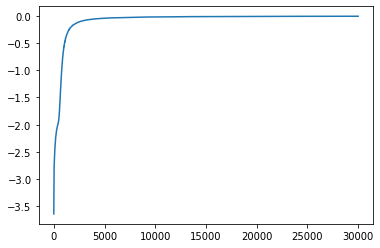

In [ ]:
test_xor()